<a href="https://colab.research.google.com/github/RaymondBrien/cherry-ml/blob/main/jupyter_notebooks/ColabOnly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook for Google Collab**

# This notebook is for use in Google Collab only, compiled in a single workflow.

## Objectives
Answer Business requirement 2: Binary Classification using Convolutional Neural Networks

* predict if a given leaf is infected or not judging by the presence of powdery mildew.
* use the CNN to map relationships between features and labels.
* build a binary classifier and generate reports.

## Inputs

* inputs/cherry-leaves-dataset/cherry-leaves/train
* inputs/cherry-leaves-dataset/cherry-leaves/test
* inputs/cherry-leaves-dataset/cherry-leaves/validation
* image shape embeddings pickle file

## Outputs
TODO





---

### ANNOTATE MODEL VERSION

In [1]:
version = 'v3'  # change as needed

Mount drive for backup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


### Import regular packages

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

### Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [3]:
import os
current_dir = os.getcwd()
current_dir

'/content'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [4]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [5]:
current_dir = os.getcwd()
current_dir

'/'

In [6]:
# manually upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ray989","key":"cbe8066ad38bc961d26ecab0236900b0"}'}

In [7]:
!pip install kaggle==1.5.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73026 sha256=bcf0ab2fd585d6d5d228cdac3aba8b9ba0c85b488e38991a3fde1848331ef338
  Stored in directory: /root/.cache/pip/wheels/70/0c/e6/79103212a102e78b8453691b905f48000219574ba7137e7207
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17


In [8]:
# allow kaggle.json access
os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd()
! chmod 600 kaggle.json

In [9]:
KaggleDatasetPath = "codeinstitute/cherry-leaves"
DestinationFolder = "inputs/cherry-leaves-dataset"  # creates new dir/dir
! kaggle datasets download -d {KaggleDatasetPath} -p {DestinationFolder}

100% 55.0M/55.0M [00:04<00:00, 15.4MB/s]
100% 55.0M/55.0M [00:04<00:00, 12.2MB/s]


In [10]:
import zipfile

try:
    with zipfile.ZipFile(DestinationFolder + '/cherry-leaves.zip', 'r') as zip_ref:
        zip_ref.extractall(DestinationFolder)
except Exception as e:
    print(e)


### Set input directory

In [11]:
my_data_dir = 'inputs/cherry-leaves-dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

### Set output directory

In [12]:

file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Old version is already available, create a new version.')
    pass
else:
    os.makedirs(name=file_path)

### Gather labels

In [13]:
try:
    labels = os.listdir(train_path)
except:
    labels = ['healthy', 'powdery_mildew']

print(f"Project Labels: {labels}")

Project Labels: ['healthy', 'powdery_mildew']


### Load image shape embeddings

In [14]:
import joblib
version_im = 'v1'  # original (should remain unchanged)

try:
    # Import saved image shape embedding pickle file
    image_shape = joblib.load(filename=f"outputs/{version_im}/image_shape.pkl")

except:
    # for google collab
    image_shape = (256, 256, 3)

finally:
    print(image_shape)



(256, 256, 3)


## Validate image files:

In [16]:
# Uncomment if using google collab

def remove_non_image_files(my_data_dir):
    print('Removing non image files...\n')
    image_extension = ('.png', '.jpg', 'jpeg')
    folders = os.listdir(my_data_dir)
    for folder in folders:
        files = os.listdir(f'{my_data_dir}/{folder}')
        # print files
        non_image = []
        image_count = []
        for given_file in files:
            try:
                if not given_file.lower().endswith(image_extension):
                    file_location = f'{my_data_dir}/{folder}/{given_file}'
                    os.remove(file_location) # remove non image file
                    non_image.append(1)
                else:
                    image_count.append(1)
                    pass
            except Exception as e:
                print(e)

        print(f'Folder: {folder} has - {len(image_count)} image files')
        print(f'Folder: {folder} has - {len(non_image)} non image files, which have been removed')

In [17]:
remove_non_image_files('inputs/cherry-leaves-dataset/cherry-leaves')

Removing non image files...

Folder: healthy has - 2104 image files
Folder: healthy has - 0 non image files, which have been removed
Folder: powdery_mildew has - 2104 image files
Folder: powdery_mildew has - 0 non image files, which have been removed


# Split train, val, test sets with dirs

In [18]:
import os
import shutil
import random
import joblib

def split_train_validation_test_images(my_data_dir, train_set_ratio, validation_set_ratio, test_set_ratio):

    # confirm ratios total 1.0
    if train_set_ratio + validation_set_ratio + test_set_ratio != 1.0:
        print('Ratios should total 1.0.')
        print('You entered:\n')
        print(f'Train radio: {train_set_ratio}')
        print(f'Validation radio: {validation_set_ratio}')
        print(f'Test radio: {test_set_ratio}')
        return

    # get classes labels
    labels = os.listdir(my_data_dir)  # expect only folder name
    if 'test' in labels:
        pass
    else:
        try:
            # create train, test folders with classes labels sub-folder
            for folder in ['train', 'validation', 'test']:
                for label in labels:
                    os.makedirs(name=f'{my_data_dir}/{folder}/{label}')

            for label in labels:

                files = os.listdir(f'{my_data_dir}/{label}')
                random.seed(42)
                random.shuffle(files)

                train_set_files_qty = int(len(files) * train_set_ratio)
                validation_set_files_qty = int(len(files) * validation_set_ratio)

                count = 1
                for file_name in files:
                    if count <= train_set_files_qty:
                        # move given file to train set
                        shutil.move(f'{my_data_dir}/{label}/{file_name}',
                                    f'{my_data_dir}/train/{label}/{file_name}')
                    elif count <= (train_set_files_qty + validation_set_files_qty):
                        # move a given file to the validation set
                        shutil.move(f'{my_data_dir}/{label}/{file_name}',
                                    f'{my_data_dir}/validation/{label}/{file_name}')
                    else:
                        # move given file to test set
                        shutil.move(f'{my_data_dir}/{label}/{file_name}',
                                    f'{my_data_dir}/test/{label}/{file_name}')

                    count += 1

                os.rmdir(f'{my_data_dir}/{label}')

        except Exception as e:
            print(e)

    print('Done!')


In [19]:
split_train_validation_test_images(
    my_data_dir='inputs/cherry-leaves-dataset/cherry-leaves',
    train_set_ratio=0.7,
    validation_set_ratio=0.1,
    test_set_ratio=0.2
)

Done!


***

# Review class distribution

* across whole dataset
* per train, test, and validation

* train- healthy: 1472 images

* train- powdery_mildew: 1472 images

* validation- healthy: 210 images

* validation- powdery_mildew: 210 images

* test- healthy: 422 images

* test- powdery_mildew: 422 images

4208 images total
--------


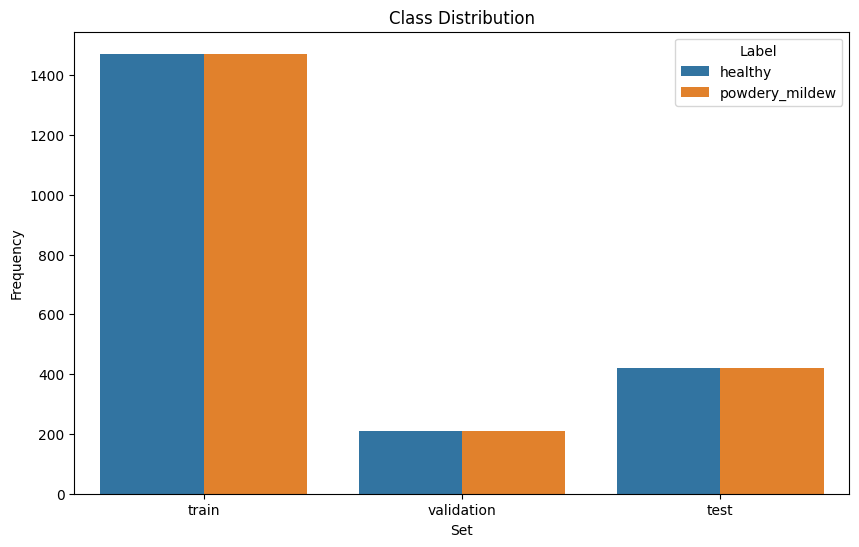



--------
                       Set  Frequency  Percent of DataSet
Label                                                    
healthy              train       1472                35.0
powdery_mildew       train       1472                35.0
healthy         validation        210                 5.0
powdery_mildew  validation        210                 5.0
healthy               test        422                10.0
powdery_mildew        test        422                10.0


In [20]:
df_freq = pd.DataFrame([])
total_images_count = 0


# gather info
for folder in ['train', 'validation', 'test']:
    for label in labels:

        path = my_data_dir + '/' + folder + '/' + label

        image_count = int(len(os.listdir(path)))
        total_images_count += image_count

        # Create a new DataFrame with the data for the current row
        new_row = pd.DataFrame({'Set': [folder], 'Label': [label], 'Frequency': [image_count]})

        # Concatenate the new row to the existing DataFrame
        df_freq = pd.concat([df_freq, new_row], ignore_index=True)

        print(f"* {folder}- {label}: {image_count} images\n")


print(f'{total_images_count} images total')
print('--------')

### plot class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x='Set', y='Frequency', hue='Label', data=df_freq)
plt.title('Class Distribution')
plt.savefig(f'{file_path}/class_distribution.png', bbox_inches='tight', dpi=600)
plt.show()
print('\n')

print('--------')

# confirm percentages of dataset
df_freq.set_index('Label', inplace=True)
df_freq['Percent of DataSet'] = round(df_freq['Frequency'] / total_images_count * 100)

print(df_freq)

We can confirm that train, validation and test set percentages of dataset are split as expected, and that there are equal amounts of both classes (healthy and powdery_mildew) in each set.

***

In [21]:
import tensorflow as tf

# Image Augmentation

### Define image data generator, initialize


In [22]:
# This function generates batches of image data with real-time data augmentation.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize
augmented_image_data = ImageDataGenerator(rotation_range=30,
                                          width_shift_range=0.15,
                                          height_shift_range=0.15,
                                          brightness_range=[0.8, 1.2],
                                          shear_range=0.1,
                                          zoom_range=0.2,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

### Define batch size

In [23]:
batch_size = 16

### Augment TRAINING image dataset


In [25]:
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True,
                                                     seed=42,
                                                     follow_links=False
                                                     )


train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Rescale validation image dataset


In [26]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Rescale test image dataset

In [27]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot augmented training images

(16, 256, 256, 3)

--------------


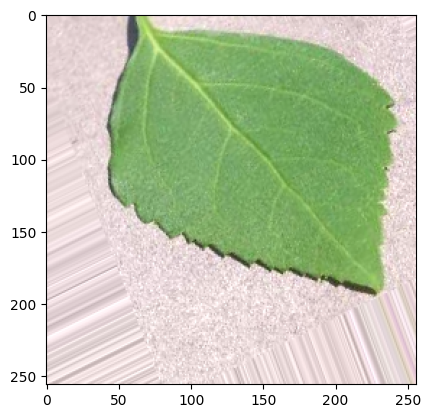

(16, 256, 256, 3)

--------------


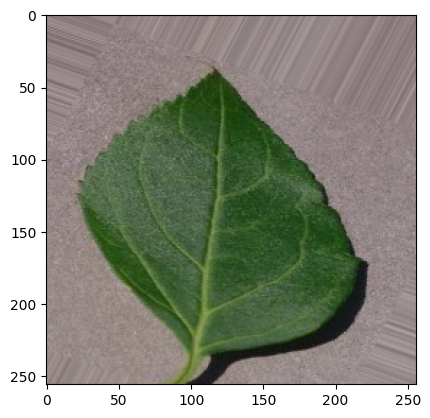

(16, 256, 256, 3)

--------------


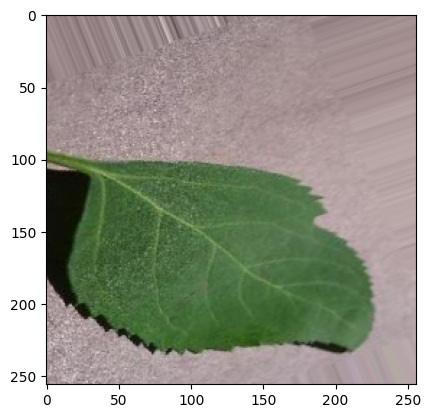

(16, 256, 256, 3)

--------------


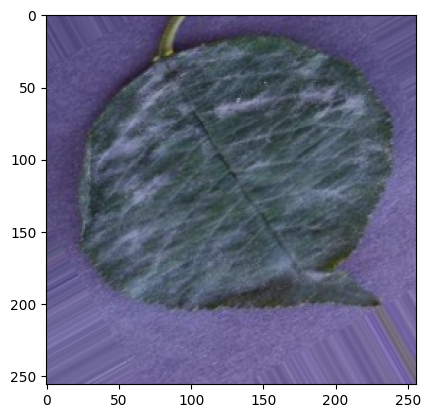

(16, 256, 256, 3)

--------------


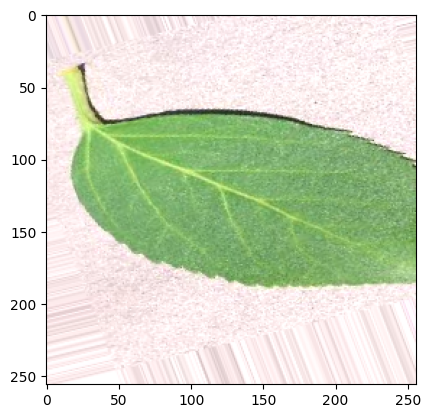

In [28]:
for _ in range(5):
    try:
        img, label = train_set.next()
    except:
        # for google collab functionality
        img, label = next(train_set)

    print(f'{img.shape}\n')  # expect: (20, 256, 256, 3)
    plt.imshow(img[0])
    print('--------------')
    plt.show()


### Plot augmented validation and test images

(16, 256, 256, 3)

--------------


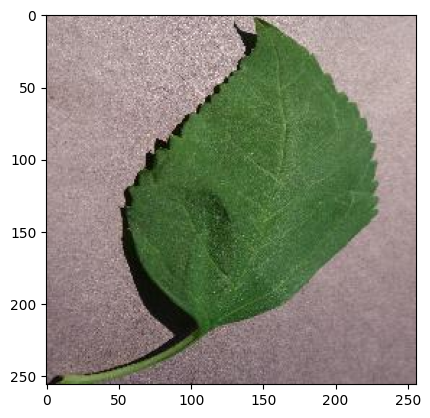

(16, 256, 256, 3)

--------------


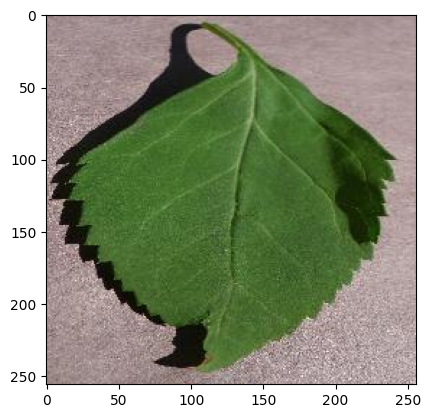

(16, 256, 256, 3)

--------------


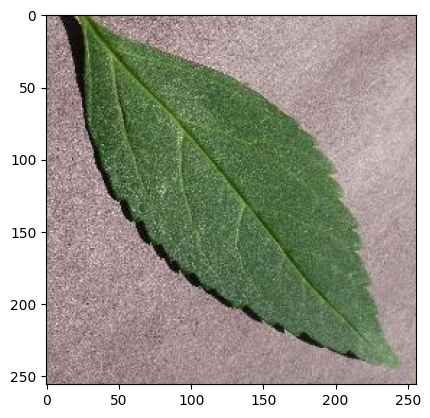

(16, 256, 256, 3)

--------------


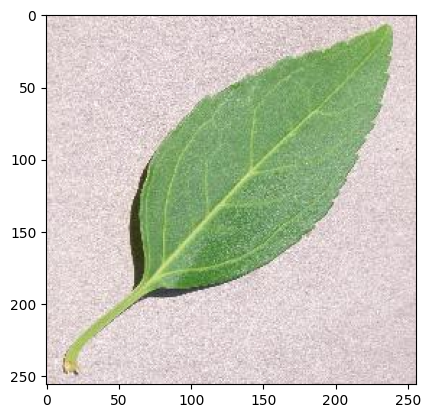

(16, 256, 256, 3)

--------------


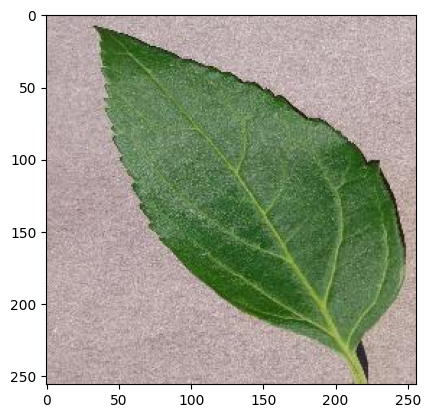

In [29]:
for _ in range(5):
    try:
        img, label = validation_set.next()
    except:
        # for google collab functionality
        img, label = next(validation_set)
    print(f'{img.shape}\n')
    plt.imshow(img[0])
    print('--------------')
    plt.show()


###  Observations
Augmented validation and test images have been standardized between 0 to 255 pixels. As you can see, the images are ugmented and are ready to be used for developing and training a CNN model.

### Save class indices

In [30]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v3/class_indices.pkl']

---

# Model Creation

---

### ML Model

* Import model packages

In [31]:
# TODO remove? for google collab functionality
# !pip install tensorflow
# !pip install keras_tuner

# TODO v3:
# TODO import keras_tuner as kt
# TODO import Adam?
# TODO add check for tf version for continuity between collab and other environments
# TODO uncomment to find collab dependencies
# TODO remove? !pip freeze > collab_requirements.txt

In [32]:
import tensorflow as tf
print(f'tf version: {tf.__version__}')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization


tf version: 2.17.0


* ### Model

In [33]:
# TODO v3 add hp as param
def create_tf_model():
    """
    Creates a CNN model for binary classification of leaf images
    TODO add to readme instead:
    Documentation of process:

    v1:
    - 4 convolution layers, c.7m trainable params. Early stopping included. No batch normalisation. Batch size 20.
    - bizarre results with 100% accuracy: concerns of data leakage.

    v2:
    - no early stopping to observe model development over longer period of epochs (25)
    - removed one convolution layer: 4 may have been too complex for the small dataset
        - instead, v2 convolution layer 3 has largest number of filters
    - v2 includes batch normalisation before final dense layer
    - results were unreadable: input ran out of data and interrupted training.
        - steps per epoch needs revision

    V3 :
    - Findings showed that augmented training data was only used on first batch and was not recalled, hense the input ran out of data on subsequent epochs.
    - no early stopping yet - allow full 25 epochs for evaluation first
    - when fitting model, steps per epoch were handled directly by keras (which should be the same as train_set.samples // batch_size), but should call augmentation each time.
    - TODO Findings:
        - this showed no input data running out
        - keep early stop

    V4 plans:
    - TODO deicde add hyperparam optimisation
    - TODO CONV layers descending order instead (128 filters, then 64, then 32)

    """
    model = Sequential()

    # Input layer: CONV1
    model.add(Conv2D(filters=32, kernel_size=(3, 3),
        input_shape=image_shape,  # average image shape
        activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2,2)))

    # CONV2
    model.add(Conv2D(filters=64, kernel_size=(3, 3),
        activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2,2)))

    # CONV3
    model.add(Conv2D(
        filters=128,  # increase
        kernel_size=(3,3),
        activation='relu', ))
    # TODO v3: consider adding normalisation here too
    # model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))

    # Flatten
    model.add(Flatten())

    # TODO v3: Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    # hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    # model.add(Dense(units=hp_units, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())

    model.add(Dropout(0.4))

    model.add(Dense(1, activation='sigmoid'))

    # TODO v3 Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    # hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Compile
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        # TODO edit optimizer=Adam(learning_rate=hp_learning_rate), - import beforehand
        metrics=[
            'accuracy',
        ])

    return model

## Model Summary

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ conv2d_30 (Conv2D)                  │ (None, 254, 254, 32)         │           896 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ max_pooling2d_30 (MaxPooling2D)     │ (None, 127, 127, 32)         │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d_31 (Conv2D)                  │ (None, 125, 125, 64)         │        18,496 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ max_pooling2d_31 (MaxPooling2D)     │ (None, 62, 62, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d_32 (Conv2D)                  │ (None, 60, 60, 128)          │        73,856 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ max_pooling2d_32 (MaxPooling2D)     │ (None, 30, 30, 128)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ flatten_10 (Flatten)                │ (None, 115200)               │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_20 (Dense)                    │ (None, 128)                  │    14,745,728 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_normalization_10              │ (None, 128)                  │           512 │    Y    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout_10 (Dropout)                │ (None, 128)                  │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_21 (Dense)                    │ (None, 1)                    │           129 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 14,839,617 (56.61 MB)

 Trainable params: 14,839,361 (56.61 MB)

 Non-trainable params: 256 (1.00 KB)

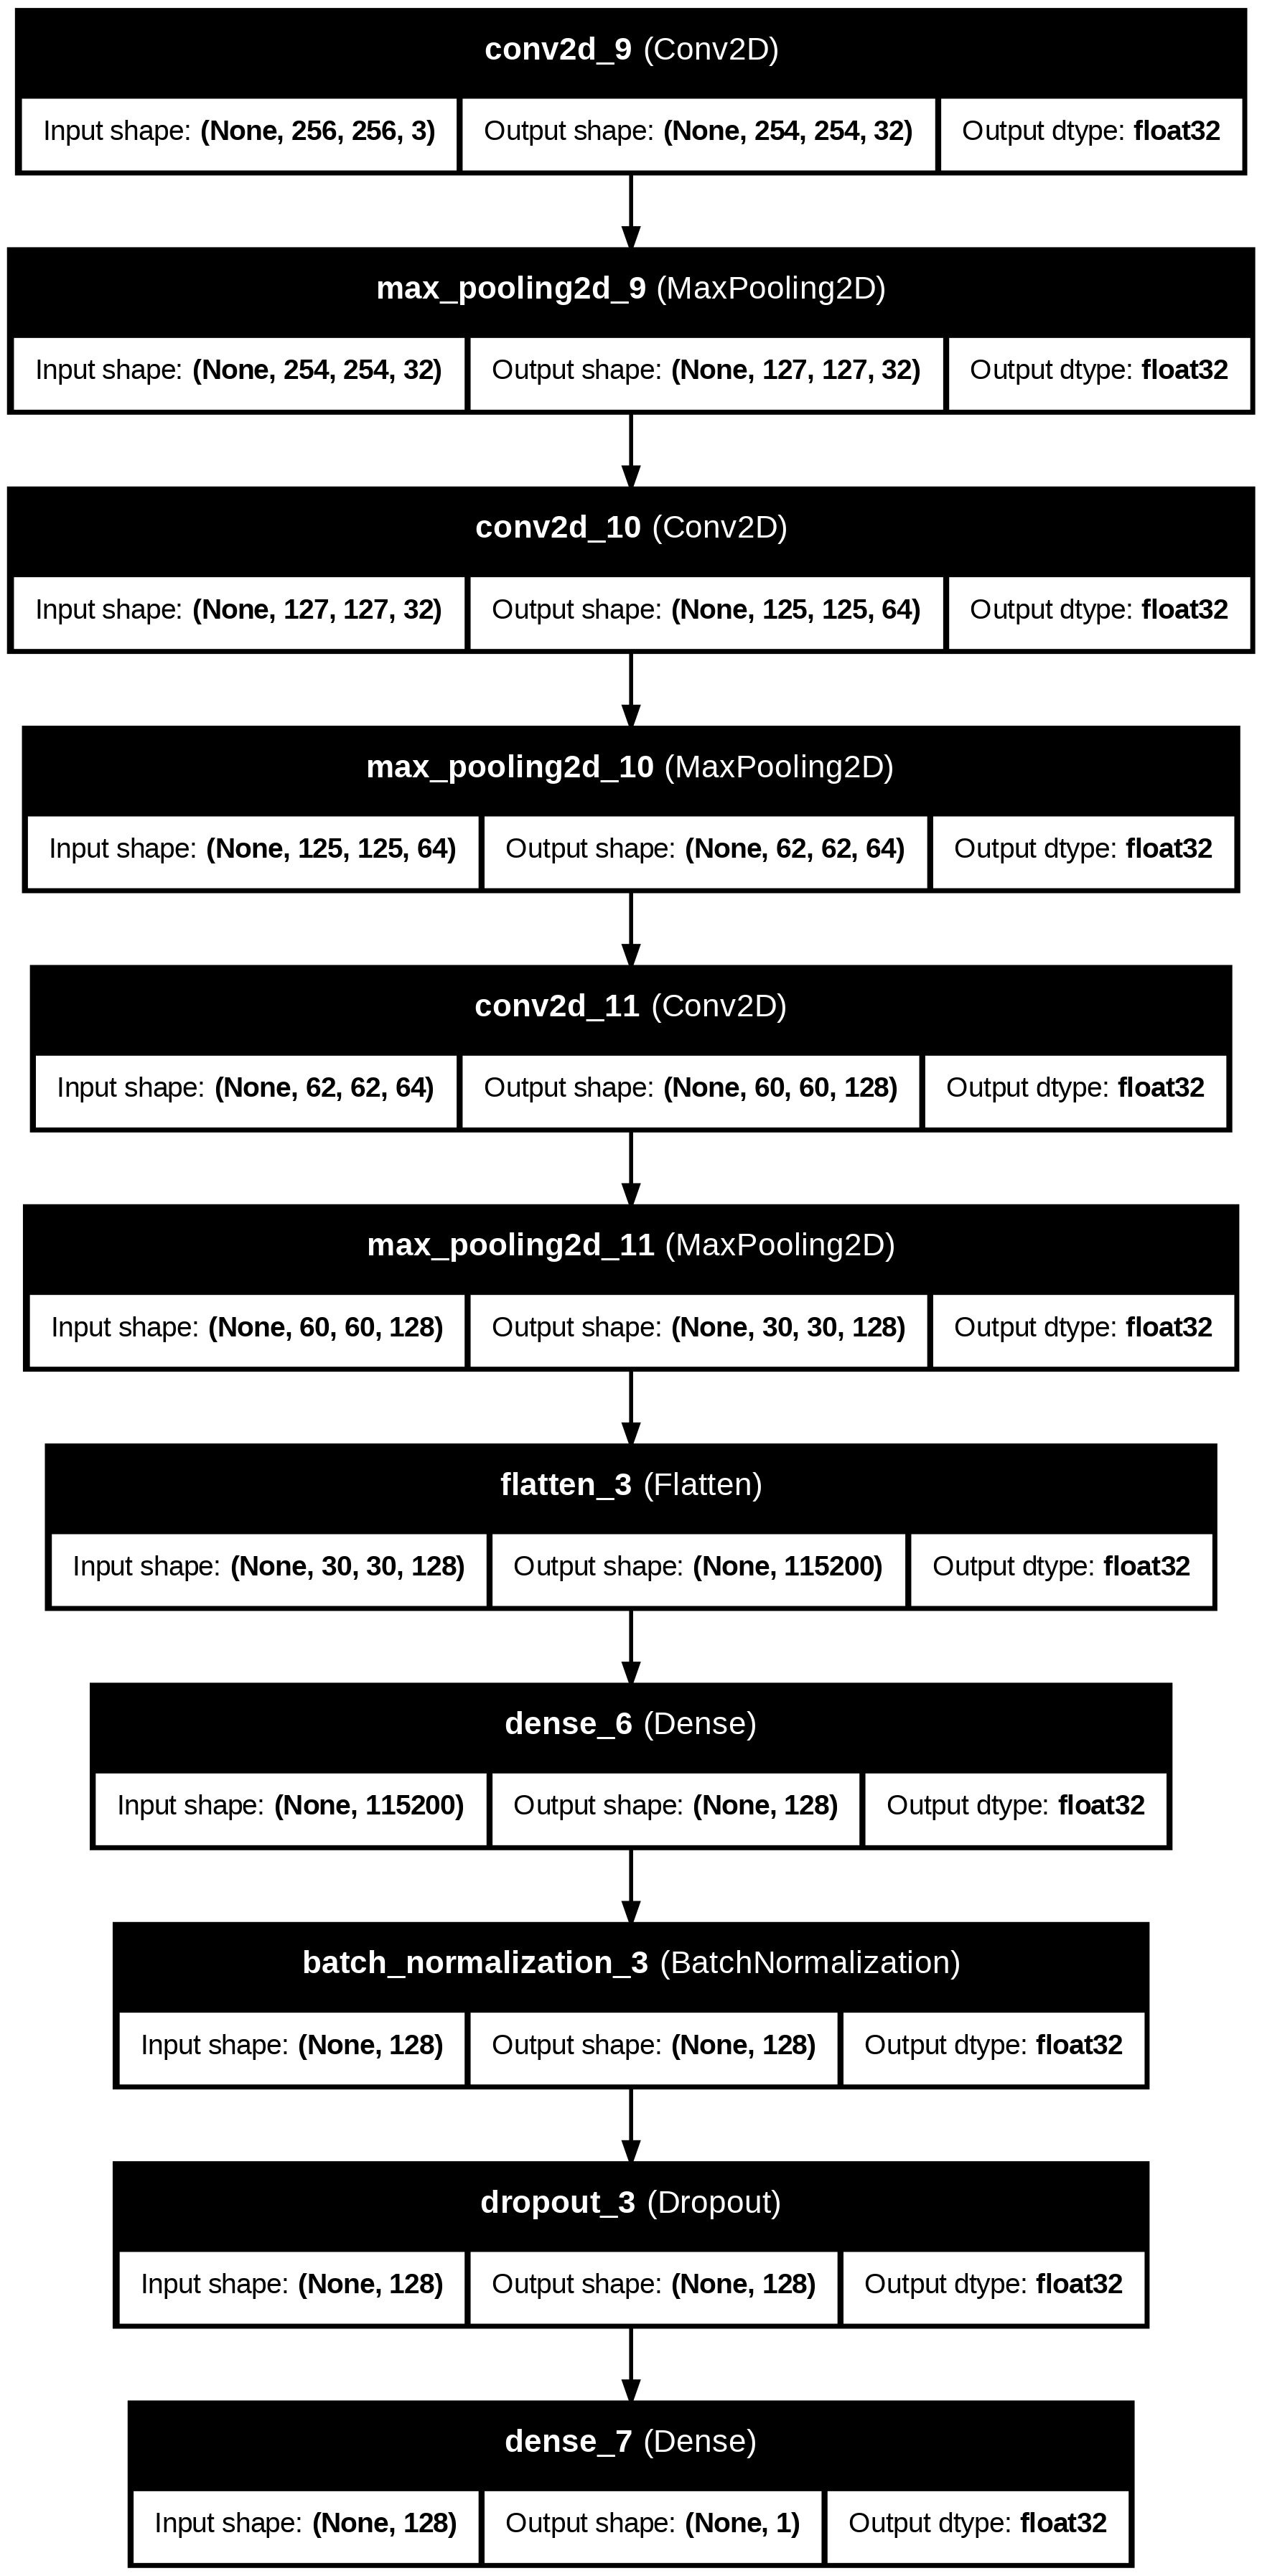

In [70]:
summary = create_tf_model().summary(show_trainable=True)

# Save model summary as PNG
from tensorflow.keras.utils import plot_model
plot_model(model, to_file=f'{file_path}/model_summary_{version}.png', show_shapes=True, show_dtype=True, show_layer_names=True)


## Early Stopping
* Avoid overfitting

In [35]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=3)  # increase patience from 3 to 10

### Run hypertune search

In [36]:
# TODO v3
# SOURCE https://www.tensorflow.org/tutorials/keras/keras_tuner

# tuner.search(img_train, label_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# # Get the optimal hyperparameters
# best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

# print(f"""
# The hyperparameter search is complete. The optimal number of units in the first densely-connected
# layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
# is {best_hps.get('learning_rate')}.
# """)
# _________
# # then reinstantiate hyermodel and train it with optimal number of epochs from above
# hypermodel = tuner.hypermodel.build(best_hps)

# # Retrain the model
# hypermodel.fit(img_train, label_train, epochs=best_epoch, validation_split=0.2)
# _________

# eval_result = hypermodel.evaluate(img_test, label_test)
# print("[test loss, test accuracy]:", eval_result)


### Visaulise Model

In [37]:
# TODO remove if neccessary
# !pip install pydot

In [38]:
from tensorflow.keras.utils import plot_model

try:
    model = create_tf_model()
    plot_model(model, show_shapes=True, to_file=f'model_{version}.png')
except Exception as e:
    print(e)
    pass


***

In [39]:
# TODO remove before submit?
print(f'Train set object: {train_set}')
print(f"Number of samples in training set: {train_set.samples}")
print(f"Number of classes: {len(train_set.classes)}")
print(f"Batch size: {batch_size}")
print(f"Current steps calculation (classes/batch_size): {len(train_set.classes) // batch_size}")
print(f"Correct steps calculation (samples/batch_size): {train_set.samples // batch_size}")
print(f"Number of validation samples: {validation_set.samples}")
print(f"Validation steps per epoch: {validation_set.samples // batch_size}")

Train set object: <keras.src.legacy.preprocessing.image.DirectoryIterator object at 0x7fc724c9bc70>
Number of samples in training set: 2944
Number of classes: 2944
Batch size: 16
Current steps calculation (classes/batch_size): 184
Correct steps calculation (samples/batch_size): 184
Number of validation samples: 420
Validation steps per epoch: 26


# Create Model

### Save checkpoints

In [41]:
import os

# check if the full path exists
checkpoint_folder = f'/workspace/outputs/{version}/training_checkpoints'

if not os.path.exists(checkpoint_folder):
    os.makedirs(checkpoint_folder)
    print('training checkpoints folder made')

# dynamically include the epoch in checkpoint file name
checkpoint_path = f"{checkpoint_folder}/cp-{{epoch:04d}}.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# callback to save model weights per epoch
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 verbose=1,
                                                 save_weights_only=True,
                                                 save_freq='epoch',
                                                 monitor='accuracy',
                                                 save_best_only=True)


### Briefly evaluate model

In [42]:
loss, acc = model.evaluate(test_set, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


53/53 - 6s - 114ms/step - accuracy: 0.5581 - loss: 0.6926
Untrained model, accuracy: 55.81%


In [ ]:
from keras.callbacks import CSVLogger

history_csv_logger = CSVLogger('training.log', separator=',', append=False)


In [43]:
# # TODO remove? Build the model with the optimal hyperparameters and train it on the data for 50 epochs
# model = tuner.hypermodel.build(best_hps)
# history = model.fit(img_train, label_train, epochs=50, validation_split=0.2)

# val_acc_per_epoch = history.history['val_accuracy']
# best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
# print('Best epoch: %d' % (best_epoch,))

In [45]:
EPOCHS = 25

try:
    model = create_tf_model()
    model.fit(train_set,
            epochs=EPOCHS,
            steps_per_epoch=None, # None is equal to the number of samples in your dataset divided by the batch size
            validation_data=validation_set,
            validation_steps=None,  #  validation will run until the validation_data dataset is exhausted
            callbacks=[early_stop, cp_callback, history_csv_logger],
            verbose=1
            )
except Exception as e:
    print(e + '\n')

    # load latest weights
    latest = tf.train.latest_checkpoint(checkpoint_dir)
    model.load_weights(latest)

    print('Model restored! Continuing...')
    # continue model training
    model.fit(train_set,
            epochs=EPOCHS,
            steps_per_epoch=None,
            validation_data=validation_set,
            validation_steps=None,
            callbacks=[early_stop, cp_callback],
            verbose=1
            )


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


183/184 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.9114 - loss: 0.2404
Epoch 1: accuracy improved from -inf to 0.93240, saving model to /workspace/outputs/v3/training_checkpoints/cp-0001.weights.h5
184/184 ━━━━━━━━━━━━━━━━━━━━ 68s 321ms/step - accuracy: 0.9116 - loss: 0.2400 - val_accuracy: 0.5000 - val_loss: 3.5513
Epoch 2/25
183/184 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.9530 - loss: 0.1539
Epoch 2: accuracy improved from 0.93240 to 0.95143, saving model to /workspace/outputs/v3/training_checkpoints/cp-0002.weights.h5
184/184 ━━━━━━━━━━━━━━━━━━━━ 56s 294ms/step - accuracy: 0.9530 - loss: 0.1539 - val_accuracy: 0.9333 - val_loss: 0.1656
Epoch 3/25
183/184 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.9650 - loss: 0.1162
Epoch 3: accuracy improved from 0.95143 to 0.96739, saving model to /workspace/outputs/v3/training_checkpoints/cp-0003.weights.h5
184/184 ━━━━━━━━━━━━━━━━━━━━ 55s 287ms/step - accuracy: 0.9650 - loss: 0.1161 - val_accuracy: 0.9810 - val_loss: 0.0488


### Save model

In [46]:
try:
    model.save(f'outputs/{version}/cherry-tree-model.h5')
    print('model saved!')
except Exception as e:
    print(e)

model saved!


***

# Evaluate Model Performance

In [47]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

def extract_performance_from_history(model):
    """
    Extract and analyze performance metrics from model training history

    Parameters:
    - model: Trained Keras model
    - history: Model training history object

    Returns:
    - Dictionary of performance metrics
    """
    # Extract metrics from history
    history = model.history.history

    performance_metrics = {
        'training': {
            'loss': history.get('loss', []),
            'accuracy': history.get('accuracy', []),
            'val_loss': history.get('val_loss', []),
            'val_accuracy': history.get('val_accuracy', [])
        }
    }

    # Calculate best epoch and corresponding metrics
    best_train_accuracy = max(performance_metrics['training']['accuracy'])
    best_val_accuracy = max(performance_metrics['training']['val_accuracy'])
    best_train_loss = min(performance_metrics['training']['loss'])
    best_val_loss = min(performance_metrics['training']['val_loss'])

    performance_metrics['best_metrics'] = {
        'best_train_accuracy': best_train_accuracy,
        'best_val_accuracy': best_val_accuracy,
        'best_train_loss': best_train_loss,
        'best_val_loss': best_val_loss
    }

    return performance_metrics

def plot_training_history(model):
    """
    Create plots for training and validation metrics

    Parameters:
    - history: Model training history object

    Returns:
    - Matplotlib figure with subplots
    """
    import matplotlib.pyplot as plt

    history = model.history

    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.savefig(f'outputs/{version}/training_accuracy.png', bbox_inches='tight', dpi=600)

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.savefig(f'outputs/{version}/training_history.png', bbox_inches='tight', dpi=600)
    return plt

def print_model_summary(model):
    """
    Print a detailed summary of the model architecture

    Parameters:
    - model: Keras model
    """
    # Capture model summary as a string
    from io import StringIO
    import sys

    # Redirect stdout to capture model summary
    old_stdout = sys.stdout
    model_summary = StringIO()
    sys.stdout = model_summary

    model.summary()

    # Restore stdout and get the summary
    sys.stdout = old_stdout
    summary_text = model_summary.getvalue()

    print("Model Architecture Summary:")
    print(summary_text)

# Example usage:
def comprehensive_model_analysis(model, train_set, validation_set, test_set, labels):
    """
    Provide comprehensive analysis of model performance

    Parameters:
    - model: Trained Keras model
    - history: Model training history
    - train_set, validation_set, test_set: Data generators
    - labels: List of class labels
    """
    # 1. Print model summary
    print(model.summary())

    # 2. Extract performance metrics
    performance_metrics = extract_performance_from_history(model)

    # 3. Print performance metrics
    print("\n--- Performance Metrics ---")
    for metric, value in performance_metrics['best_metrics'].items():
        print(f"{metric.replace('_', ' ').title()}: {value:.4f}")

    # 4. Plot training history
    plt = plot_training_history(model)
    plt.show()

    # 5. TODO Generate confusion matrices
    # print("\n--- Confusion Matrices ---")
    # clf_performance(model, train_set, validation_set, test_set, labels)




In [104]:
comprehensive_model_analysis(model, train_set, validation_set, test_set, labels)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,839,619 (56.61 MB)

 Trainable params: 14,839,361 (56.61 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 2 (12.00 B)

None


AttributeError: 'Sequential' object has no attribute 'history'

### Plot model training loss and accuracy

In [81]:
joblib.dump(value=performance_metrics,filename=f"outputs/{version}/performance_metrics.pkl")


NameError: name 'performance_metrics' is not defined

### Evaluate and save

In [52]:
# pd.Dataframe(model.evaluate(test_set))
# ev[0], [1],plot(style='.-')
# plt.title('Test Evaluation')
try:
    eval1 = model.evaluate(test_set)
    evaluation_train = model.evaluate(train_set)
    evaluation_val = model.evaluate(validation_set)
except Exception as e:
    print(e)
    pass

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9989 - loss: 0.0072
184/184 ━━━━━━━━━━━━━━━━━━━━ 52s 282ms/step - accuracy: 0.9929 - loss: 0.0262
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 1.0000 - loss: 0.0043


In [55]:
joblib.dump(value=eval1,filename=f"outputs/{version}/test-evaluation.pkl")
joblib.dump(value=evaluation_train,filename=f"outputs/{version}/train-evaluation.pkl")
joblib.dump(value=evaluation_val,filename=f"outputs/{version}/val-evaluation.pkl")

['outputs/v3/val-evaluation.pkl']

Save backup model to drive

In [90]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,518,341 (169.82 MB)

 Trainable params: 14,839,361 (56.61 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 29,678,724 (113.22 MB)

In [62]:
from google.colab import drive
drive.mount('/content/drive')


!cp -r outputs/{version} /content/drive/MyDrive/{version}


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Run Live Prediction

Image shape: (256, 256), Image mode: RGB


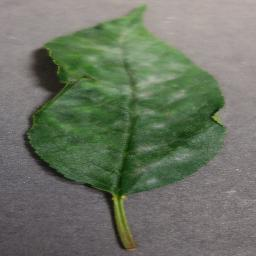

In [56]:
from tensorflow.keras.preprocessing import image

pointer = 66  # TODO change to random within length of dir
label = labels[1]  # select Uninfected or Parasitised # TODO change to random (0 or 1) and print image class too

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

In [57]:
pred_img = image.img_to_array(pil_image)
pred_img = np.expand_dims(pred_img, axis=0)/255
print(pred_img.shape)
pred_img

(1, 256, 256, 3)


array([[[[0.60784316, 0.5686275 , 0.57254905],
         [0.60784316, 0.5686275 , 0.57254905],
         [0.60784316, 0.5686275 , 0.57254905],
         ...,
         [0.7254902 , 0.68235296, 0.6745098 ],
         [0.72156864, 0.6784314 , 0.67058825],
         [0.72156864, 0.6784314 , 0.67058825]],

        [[0.60784316, 0.5686275 , 0.57254905],
         [0.60784316, 0.5686275 , 0.57254905],
         [0.6039216 , 0.5647059 , 0.5686275 ],
         ...,
         [0.72156864, 0.6784314 , 0.67058825],
         [0.72156864, 0.6784314 , 0.67058825],
         [0.72156864, 0.6784314 , 0.67058825]],

        [[0.6117647 , 0.57254905, 0.5764706 ],
         [0.60784316, 0.5686275 , 0.57254905],
         [0.6039216 , 0.5647059 , 0.5686275 ],
         ...,
         [0.7137255 , 0.67058825, 0.6627451 ],
         [0.7137255 , 0.67058825, 0.6627451 ],
         [0.7137255 , 0.67058825, 0.6627451 ]],

        ...,

        [[0.29803923, 0.2784314 , 0.29411766],
         [0.2901961 , 0.27058825, 0.28627452]

In [58]:
# predict class probability on test image
pred_proba = model.predict(pred_img)[0, 0] # TODO why 0 0?

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
  pred_proba = 1 - pred_proba

print(f'Prediction: {pred_class}\nConfidence: {pred_proba*100:.1f}%') # TODO do I want more decimal places?

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediction: powdery_mildew
Confidence: 98.4%


## Save backup files to drive

Save tf version used in notebook to file

In [73]:
tf_version = tf.__version__
tf_version

joblib.dump(value=tf_version,filename=f"outputs/{version}/tf_version.pkl")

['outputs/v3/tf_version.pkl']

In [76]:
!pip freeze > outputs/{version}/colab_requirements.txt

In [105]:
from google.colab import drive
drive.mount('/content/drive')


!cp -r outputs/{version} /content/drive/MyDrive/{version}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***